<a href="https://colab.research.google.com/github/square-1111/Apery/blob/master/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Importing libraries and eager execution

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

import tensorflow.keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

from PIL import Image

Using TensorFlow backend.


In [0]:
tf.enable_eager_execution()

## Step 1: Preprocess and Deprocess Image

In [0]:
def load_img(image_path):
  max_dim = 512
  img = Image.open(image_path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path)
    img = preprocess_input(img)
    return img


In [0]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x = np.reshape(x, [x.shape[1],x.shape[2],x.shape[3]])
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


## Step 2: Load image

### Content Image

In [8]:
from google.colab import files

content_path = files.upload()

Saving photo6100652494943266912.jpg to photo6100652494943266912 (2).jpg


In [9]:
import os
print("hello world")
print(list(content_path)[0])
noise_path = list(content_path)[0]

content_path = list(content_path)[0]


content_path_tmp = content_path.strip().replace(" ", "_")

if content_path != content_path_tmp:
  os.rename(content_path, content_path_tmp)
  content_path = content_path_tmp
  
print("Content image filename :", content_path)

content = preprocess_image(content_path)

hello world
photo6100652494943266912.jpg
Content image filename : photo6100652494943266912.jpg


### Style Image

In [10]:
from google.colab import files

style_path = files.upload()

Saving scream.jpg to scream (1).jpg


In [11]:
import os

style_path = list(style_path)[0]
style_path_tmp = style_path.strip().replace(" ", "_")

if style_path != style_path_tmp:
  os.rename(style_path, style_path_tmp)
  style_path = style_path_tmp
 
print("style image filename :", style_path)

style = preprocess_image(style_path)

style image filename : scream.jpg


### Create noise-image  
We initialize the noise image as content image.

In [64]:
import os

noise_path_tmp = noise_path.strip().replace(" ", "_")

if noise_path != noise_path_tmp:
  os.rename(noise_path, noise_path_tmp)
  noise_path = noise_path_tmp
  
print("Content image filename :", noise_path)

noise = preprocess_image(noise_path)

Content image filename : photo6100652494943266912.jpg


Initializing the images to tensorflow variables.

In [0]:
content = tf.Variable(content,dtype = tf.float32)
noise = tf.Variable(noise,dtype = tf.float32)
style = tf.Variable(style,dtype = tf.float32)

## Step 3: Load VGG19 CNN architecture
Using VGG19 architecture from Keras.

In [0]:
vgg = VGG19(include_top=False, weights='imagenet')

vgg.trainable = False

## Step 4: Calculating Loss

### Selecting layer 

In [0]:
content_layer = ['block4_conv2']

model_content = Model(inputs=vgg.input, outputs=vgg.get_layer(content_layer[0]).output)
model_content.trainable = False



style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

model_style = []
for layer in style_layers:
  model_style.append( Model(inputs=vgg.input, outputs=vgg.get_layer(layer).output))

for i in range(len(style_layers)):
  model_style[i].trainable = False


### Reshaping the matrix

In [0]:
def reshape_feature(feature):
  shapes = feature.shape
  matrix = tf.reshape(feature, [-1, shapes[3] ])
  return matrix

### Creating Gram Matrix


In [0]:
def gram_matrix(feature):
  matrix = reshape_feature(feature)
  return  tf.matmul(tf.transpose(matrix),matrix)/ tf.cast(feature.shape[0], tf.float32)

### Content loss

In [0]:
def content_loss(content_img, noise_img):
  content_features = model_content(content_img)
  canvas_features = model_content(noise_img)
  
  canvas_features = reshape_feature(canvas_features)
  content_features = reshape_feature(content_features)
  
  return tf.reduce_mean(tf.square(canvas_features-content_features))

### Style loss

In [0]:
def style_loss(canvas, style_image):
  
  style_features = [model_style[i](style_image) for i in range(len(model_style))]
  
  canvas_features = [model_style[i](canvas) for i in range(len(model_style))]
  sum_ar = []
  for i in range(len(style_features)):
    c_gram = gram_matrix(canvas_features[i])
    s_gram = gram_matrix(style_features[i])

    sum_ar.append(tf.reduce_mean(tf.square(c_gram-s_gram)))
    
    
  sum = tf.reduce_mean(sum_ar)
  return sum

### Total Variation Loss

In [0]:
def total_variation_loss(noise_img):
  n,height,width,nc = noise_img.shape
  a = tf.subtract(noise_img[:,:height-1,:width-1,:],noise_img[:,1:,:width-1,:])
  b = tf.subtract(noise_img[:,:height-1,:width-1,:],noise_img[:,:height-1,1:,:])
  return tf.reduce_sum(tf.pow(tf.add(tf.square(a), tf.square(b)),1.25))

### Total Loss
$$ total_{loss} = \alpha * content_{loss} + \beta * style_{loss} + \gamma*variation_{loss}$$

In [0]:
def total_loss(noise_img, cont_img, style_img, alpha, beta, total_variation_weight):
  loss = alpha*content_loss(noise_img,cont_img) + beta*style_loss(noise_img,style_img) + total_variation_weight*total_variation_loss(noise_img)
  print(loss)
  return loss

## Step 5: Minimizing Loss


### Automatic Differentiation

In [0]:
def grad(alpha, beta, total_variation_weight):
    with tf.GradientTape() as tape:
      loss = total_loss(noise, content,style,alpha,beta, total_variation_weight)
    return tape.gradient(loss,[noise])
    

### Using Adam Optimizer

In [0]:
def grad_desc( iterations):
  global noise  
  opt = tf.train.AdamOptimizer(learning_rate=10.0, beta1=0.99, epsilon=1e-1)
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means  
  
  for i in range(iterations):
    grads = grad(50000,0.005,90000)
    opt.apply_gradients([(grads[0], noise)])
    clipped = tf.clip_by_value(noise, min_vals, max_vals)
    noise.assign(clipped)

In [70]:
grad_desc(20)

tot 349948576.0
tf.Tensor(2229001600000000.0, shape=(), dtype=float32)
tot 865575296.0
tf.Tensor(1786096600000000.0, shape=(), dtype=float32)
tot 1170282752.0
tf.Tensor(1428353200000000.0, shape=(), dtype=float32)
tot 1288589568.0
tf.Tensor(1199090700000000.0, shape=(), dtype=float32)
tot 1331326592.0
tf.Tensor(994249000000000.0, shape=(), dtype=float32)
tot 1335251712.0
tf.Tensor(823767750000000.0, shape=(), dtype=float32)
tot 1330475520.0
tf.Tensor(681245700000000.0, shape=(), dtype=float32)
tot 1333702912.0
tf.Tensor(572705500000000.0, shape=(), dtype=float32)
tot 1347493376.0
tf.Tensor(492863670000000.0, shape=(), dtype=float32)
tot 1366586368.0
tf.Tensor(433776160000000.0, shape=(), dtype=float32)
tot 1384976256.0
tf.Tensor(389850660000000.0, shape=(), dtype=float32)
tot 1400027904.0
tf.Tensor(356605500000000.0, shape=(), dtype=float32)
tot 1411442304.0
tf.Tensor(331333540000000.0, shape=(), dtype=float32)
tot 1419034624.0
tf.Tensor(311560450000000.0, shape=(), dtype=float32)
tot 

In [71]:
gen_img = deprocess_image(noise.numpy())
sty_img = deprocess_image(style.numpy())
con_img = deprocess_image(content.numpy())
gen_img.shape

(512, 384, 3)

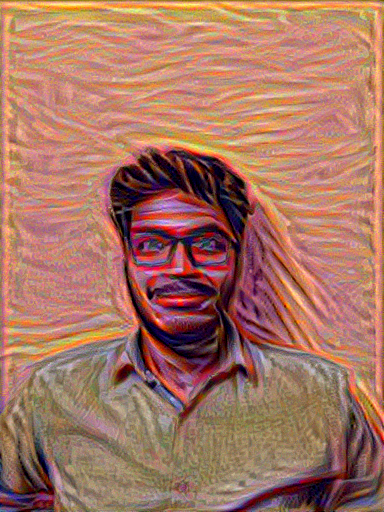

In [26]:
from PIL import Image
img = Image.fromarray(gen_img,'RGB')
img.show()
img